# In this lab, we will be using the Sakila database of movie rentals.
# In order to optimize our inventory, we would like to know which films will be rented next month and
# we are asked to create a model to predict it.
# We consider 2005 as the year of the data 

In [12]:
#!pip install imblearn
#! pip install sqlalchemy
#! pip install PyMySQL

In [13]:
# importing some stuff like some useful libraries
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
password = getpass.getpass()

········


## 1.
## Create a query or queries to extract the information you think may be relevant for building the prediction model.
## It should include some film features and some rental features.

In [14]:
# get the data
rental = pd.read_sql('rental', 'mysql+pymysql://root:' + password + '@localhost/sakila')
film = pd.read_sql('film', 'mysql+pymysql://root:' + password + '@localhost/sakila')

C:\Users\Admin\anaconda3\lib\site-packages\pandas\io\sql.py:618: SAWarning: Did not recognize type 'geometry' of column 'location'
  pandas_sql.meta.reflect(only=[sql])


In [15]:
# for films
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''select
f.film_id, f.title, f.rental_duration, f.rental_rate, f.length, f.rating, r.rental_id, r.customer_id, act.number_of_actors, inv.number_of_inventories, c.name as category
from sakila.film as f
left join sakila.inventory as i on i.film_id = f.film_id
left join sakila.rental as r on r.inventory_id = i.inventory_id
join sakila.film_actor as fa on fa.film_id = f.film_id
join sakila.actor as a on a.actor_id = fa.actor_id
join sakila.film_category as fc on fc.film_id = f.film_id
join sakila.category as c on c.category_id = fc.category_id
left join (select count(actor_id) as number_of_actors, film_id from sakila.film_actor group by film_id) as act on act.film_id = f.film_id
left join (select count(inventory_id) as number_of_inventories, film_id from sakila.inventory group by film_id) as inv on inv.film_id = f.film_id
where year(rental_date) = 2005
group by i.film_id;'''

In [16]:
# for rentals, we will use it later
query1 = '''select 
title, month(rental_date) as rental_month
from film as f
left join inventory as i on i.film_id = f.film_id
left join rental as r on r.inventory_id = i.inventory_id
where year(r.rental_date) = 2005;'''
rental = pd.read_sql_query(query1, engine)

## 2.
## Read the data into a Pandas dataframe.

In [17]:
# for films
data = pd.read_sql_query(query, engine)
data

,film_id,title,rental_duration,rental_rate,length,rating,rental_id,customer_id,number_of_actors,number_of_inventories,category
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,4863,431,10,8,Documentary
1,2,ACE GOLDFINGER,3,4.99,48,G,10310,271,4,3,Horror
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,6999,224,5,4,Documentary
3,4,AFFAIR PREJUDICE,5,2.99,117,G,6493,184,5,7,Horror
4,5,AFRICAN EGG,6,2.99,130,G,552,106,5,3,Family
...,...,...,...,...,...,...,...,...,...,...,...
950,996,YOUNG LANGUAGE,6,0.99,183,G,4969,231,5,2,Documentary
951,997,YOUTH KICK,4,0.99,179,NC-17,7240,324,5,2,Music
952,998,ZHIVAGO CORE,6,0.99,105,NC-17,1884,305,6,2,Horror
953,999,ZOOLANDER FICTION,5,2.99,101,R,3734,37,5,5,Children


In [18]:
# for rentals we find the exact month of rental, we will use it later
data1 = pd.read_sql_query(query1, engine)
data1

,title,rental_month
0,ACADEMY DINOSAUR,7
1,ACADEMY DINOSAUR,8
2,ACADEMY DINOSAUR,8
3,ACADEMY DINOSAUR,5
4,ACADEMY DINOSAUR,6
...,...,...
15857,ZORRO ARK,5
15858,ZORRO ARK,6
15859,ZORRO ARK,7
15860,ZORRO ARK,7


In [19]:
# checking if the month of the rental is May, we will also use it later
rental['rental_month'] = np.where(rental['rental_month'] == 5,1,0)
rental = rental.groupby(['title'])['rental_month'].max()
rental = pd.DataFrame(rental).reset_index()
rental

,title,rental_month
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1
...,...,...
953,YOUNG LANGUAGE,0
954,YOUTH KICK,0
955,ZHIVAGO CORE,1
956,ZOOLANDER FICTION,1


In [20]:
# join the tables
data = data.join(rental.set_index('title'), on='title')
data

,film_id,title,rental_duration,rental_rate,length,rating,rental_id,customer_id,number_of_actors,number_of_inventories,category,rental_month
0,1,ACADEMY DINOSAUR,6,0.99,86,PG,4863,431,10,8,Documentary,1
1,2,ACE GOLDFINGER,3,4.99,48,G,10310,271,4,3,Horror,0
2,3,ADAPTATION HOLES,7,2.99,50,NC-17,6999,224,5,4,Documentary,1
3,4,AFFAIR PREJUDICE,5,2.99,117,G,6493,184,5,7,Horror,1
4,5,AFRICAN EGG,6,2.99,130,G,552,106,5,3,Family,1
...,...,...,...,...,...,...,...,...,...,...,...,...
950,996,YOUNG LANGUAGE,6,0.99,183,G,4969,231,5,2,Documentary,0
951,997,YOUTH KICK,4,0.99,179,NC-17,7240,324,5,2,Music,0
952,998,ZHIVAGO CORE,6,0.99,105,NC-17,1884,305,6,2,Horror,1
953,999,ZOOLANDER FICTION,5,2.99,101,R,3734,37,5,5,Children,1


## 3.
## Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [21]:
# Let's find the shape of the dataframe
data.shape

(955, 12)

In [22]:
# Show the column names of the dataframe in a list 
list(data.columns)

['film_id',
 'title',
 'rental_duration',
 'rental_rate',
 'length',
 'rating',
 'rental_id',
 'customer_id',
 'number_of_actors',
 'number_of_inventories',
 'category',
 'rental_month']

In [23]:
# type of each column
data.dtypes
# data.info()

film_id                    int64
title                     object
rental_duration            int64
rental_rate              float64
length                     int64
rating                    object
rental_id                  int64
customer_id                int64
number_of_actors           int64
number_of_inventories      int64
category                  object
rental_month               int32
dtype: object

In [24]:
# description of the dataframe 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
film_id,955.0,502.728796,287.660572,1.00,255.50,505.00,751.50,1000.00
rental_duration,955.0,4.967539,1.405289,3.00,4.00,5.00,6.00,7.00
rental_rate,955.0,2.975340,1.641890,0.99,0.99,2.99,4.99,4.99
length,955.0,115.363351,40.430401,46.00,80.00,114.00,149.50,185.00
rental_id,955.0,4481.534031,3393.656781,6.00,1316.00,3824.00,7002.00,11486.00
customer_id,955.0,294.797906,170.041720,1.00,148.50,292.00,435.50,598.00
number_of_actors,955.0,5.493194,2.312736,1.00,4.00,5.00,7.00,15.00
number_of_inventories,955.0,4.783246,1.817724,2.00,3.00,5.00,6.00,8.00
rental_month,955.0,0.716230,0.451063,0.00,0.00,1.00,1.00,1.00


In [25]:
# checking null values
data.isna().sum()
# there are no null values

film_id                  0
title                    0
rental_duration          0
rental_rate              0
length                   0
rating                   0
rental_id                0
customer_id              0
number_of_actors         0
number_of_inventories    0
category                 0
rental_month             0
dtype: int64

In [26]:
# finding categorical columns
data.select_dtypes(['object']).columns

Index(['title', 'rating', 'category'], dtype='object')

In [27]:
# finding numerical columns
data.select_dtypes(include=[np.number]).columns.values

array(['film_id', 'rental_duration', 'rental_rate', 'length', 'rental_id',
       'customer_id', 'number_of_actors', 'number_of_inventories',
       'rental_month'], dtype=object)

In [28]:
# film_id,rental_id and customer_id are important for the predictions, but we won't use it as features (unique values)
data = data.set_index('rental_id','customer_id','film_id')
data

C:\Users\Admin\AppData\Local\Temp/ipykernel_4204/2683591745.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  data = data.set_index('rental_id','customer_id','film_id')


,,film_id,title,rental_duration,rental_rate,length,rating,customer_id,number_of_actors,number_of_inventories,category,rental_month
,rental_id,,,,,,,,,,,
0,4863,1,ACADEMY DINOSAUR,6,0.99,86,PG,431,10,8,Documentary,1
1,10310,2,ACE GOLDFINGER,3,4.99,48,G,271,4,3,Horror,0
2,6999,3,ADAPTATION HOLES,7,2.99,50,NC-17,224,5,4,Documentary,1
3,6493,4,AFFAIR PREJUDICE,5,2.99,117,G,184,5,7,Horror,1
4,552,5,AFRICAN EGG,6,2.99,130,G,106,5,3,Family,1
...,...,...,...,...,...,...,...,...,...,...,...,...
950,4969,996,YOUNG LANGUAGE,6,0.99,183,G,231,5,2,Documentary,0
951,7240,997,YOUTH KICK,4,0.99,179,NC-17,324,5,2,Music,0
952,1884,998,ZHIVAGO CORE,6,0.99,105,NC-17,305,6,2,Horror,1


In [29]:
# the same with customer_id
data = data.set_index('customer_id','film_id')
data

C:\Users\Admin\AppData\Local\Temp/ipykernel_4204/2532575136.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  data = data.set_index('customer_id','film_id')


,film_id,title,rental_duration,rental_rate,length,rating,number_of_actors,number_of_inventories,category,rental_month
customer_id,,,,,,,,,,
431,1,ACADEMY DINOSAUR,6,0.99,86,PG,10,8,Documentary,1
271,2,ACE GOLDFINGER,3,4.99,48,G,4,3,Horror,0
224,3,ADAPTATION HOLES,7,2.99,50,NC-17,5,4,Documentary,1
184,4,AFFAIR PREJUDICE,5,2.99,117,G,5,7,Horror,1
106,5,AFRICAN EGG,6,2.99,130,G,5,3,Family,1
...,...,...,...,...,...,...,...,...,...,...
231,996,YOUNG LANGUAGE,6,0.99,183,G,5,2,Documentary,0
324,997,YOUTH KICK,4,0.99,179,NC-17,5,2,Music,0
305,998,ZHIVAGO CORE,6,0.99,105,NC-17,6,2,Horror,1


In [30]:
# the same with film_id
data = data.set_index('film_id')
data
# actually now we have only film_id as index and the other columns are the features we need 

,title,rental_duration,rental_rate,length,rating,number_of_actors,number_of_inventories,category,rental_month
film_id,,,,,,,,,
1,ACADEMY DINOSAUR,6,0.99,86,PG,10,8,Documentary,1
2,ACE GOLDFINGER,3,4.99,48,G,4,3,Horror,0
3,ADAPTATION HOLES,7,2.99,50,NC-17,5,4,Documentary,1
4,AFFAIR PREJUDICE,5,2.99,117,G,5,7,Horror,1
5,AFRICAN EGG,6,2.99,130,G,5,3,Family,1
...,...,...,...,...,...,...,...,...,...
996,YOUNG LANGUAGE,6,0.99,183,G,5,2,Documentary,0
997,YOUTH KICK,4,0.99,179,NC-17,5,2,Music,0
998,ZHIVAGO CORE,6,0.99,105,NC-17,6,2,Horror,1


In [31]:
# for every categorical column we find and count every value in each feature
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

ACADEMY DINOSAUR      1
PERSONAL LADYBUGS     1
PARK CITIZEN          1
PARTY KNOCK           1
PAST SUICIDES         1
                     ..
FURY MURDER           1
GABLES METROPOLIS     1
GALAXY SWEETHEARTS    1
GAMES BOWFINGER       1
ZORRO ARK             1
Name: title, Length: 955, dtype: int64 

PG-13    213
NC-17    202
R        187
PG       183
G        170
Name: rating, dtype: int64 

Sports         72
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
New            60
Drama          60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Horror         53
Travel         52
Music          51
Name: category, dtype: int64 



In [32]:
# using lowercase letters in the values of categorical columns
def lowerletters(x):
    x = x.lower()
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

data['title'] = list(map(lowerletters, data['title']))
data['rating'] = list(map(lowerletters, data['rating']))
data['category'] = list(map(lowerletters, data['category']))

data['title'], data['rating'], data['category']

(film_id
 1        academy dinosaur
 2          ace goldfinger
 3        adaptation holes
 4        affair prejudice
 5             african egg
               ...        
 996        young language
 997            youth kick
 998          zhivago core
 999     zoolander fiction
 1000            zorro ark
 Name: title, Length: 955, dtype: object,
 film_id
 1          pg
 2           g
 3       nc-17
 4           g
 5           g
         ...  
 996         g
 997     nc-17
 998     nc-17
 999         r
 1000    nc-17
 Name: rating, Length: 955, dtype: object,
 film_id
 1       documentary
 2            horror
 3       documentary
 4            horror
 5            family
            ...     
 996     documentary
 997           music
 998          horror
 999        children
 1000         comedy
 Name: category, Length: 955, dtype: object)

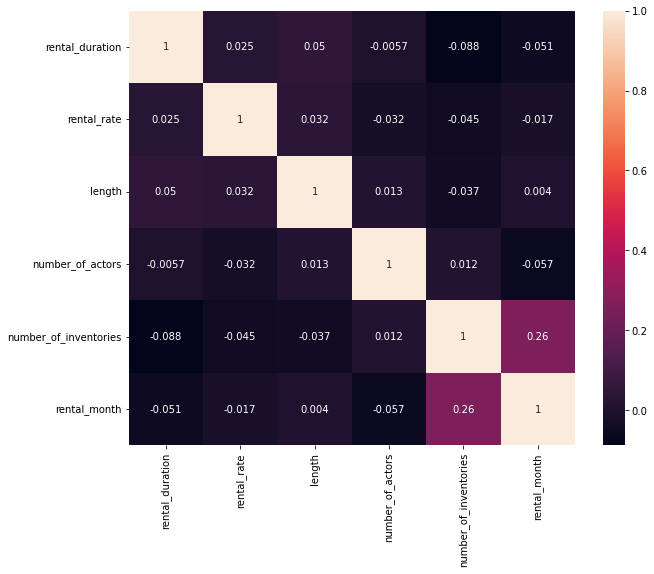

In [33]:
# EDA
# heatmap for numerical values
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()
# there is no strong correlation among the features

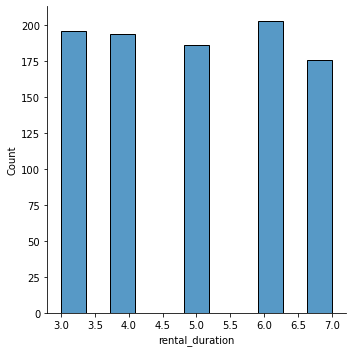

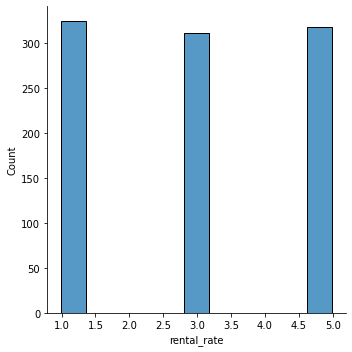

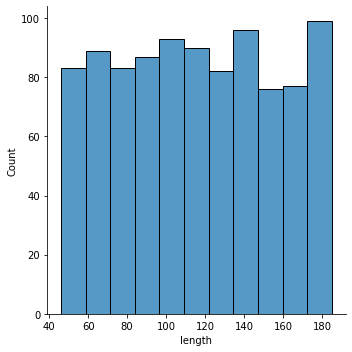

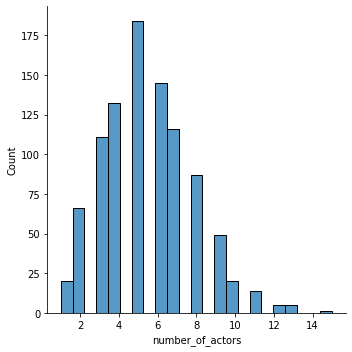

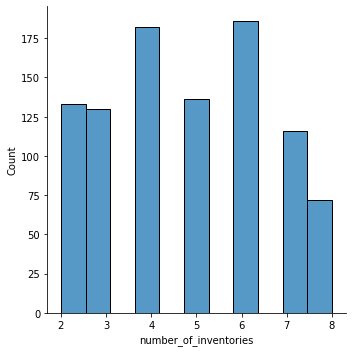

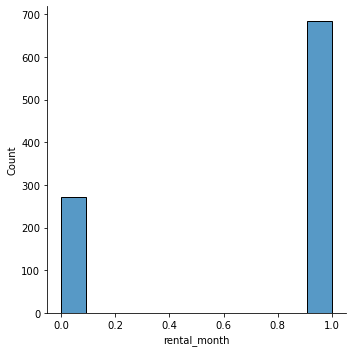

In [34]:
# let's also check the distribution plots of every numerical column
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

In [35]:
# we use encoding and scaling later 

## 4.
## Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [36]:
# Create the query. The same from question 2
query1 = '''select 
title, month(rental_date) as rental_month
from film as f
left join inventory as i on i.film_id = f.film_id
left join rental as r on r.inventory_id = i.inventory_id
where year(r.rental_date) = 2005;'''
rental = pd.read_sql_query(query1, engine)

In [37]:
# Creating boolean indicating if it was rented last month
rental['rental_month'] = np.where(rental['rental_month'] == 5,1,0)
rental = rental.groupby(['title'])['rental_month'].max()
rental = pd.DataFrame(rental).reset_index()
rental

,title,rental_month
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1
...,...,...
953,YOUNG LANGUAGE,0
954,YOUTH KICK,0
955,ZHIVAGO CORE,1
956,ZOOLANDER FICTION,1


In [38]:
# the films that were rented last month 
rentals_may = rental[(rental['rental_month'] == 1)]
rentals_may

,title,rental_month
0,ACADEMY DINOSAUR,1
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1
5,AGENT TRUMAN,1
...,...,...
951,WYOMING STORM,1
952,YENTL IDAHO,1
955,ZHIVAGO CORE,1
956,ZOOLANDER FICTION,1


In [39]:
# we have already made the process in the beginning (question 2)
data.head(10)

,title,rental_duration,rental_rate,length,rating,number_of_actors,number_of_inventories,category,rental_month
film_id,,,,,,,,,
1,academy dinosaur,6,0.99,86,pg,10,8,documentary,1
2,ace goldfinger,3,4.99,48,g,4,3,horror,0
3,adaptation holes,7,2.99,50,nc-17,5,4,documentary,1
4,affair prejudice,5,2.99,117,g,5,7,horror,1
5,african egg,6,2.99,130,g,5,3,family,1
6,agent truman,3,2.99,169,pg,7,6,foreign,1
7,airplane sierra,6,4.99,62,pg-13,5,5,comedy,0
8,airport pollock,6,4.99,54,r,4,4,horror,1
9,alabama devil,3,2.99,114,pg-13,9,5,horror,0


## 5.
## Create a logistic regression model to predict this variable from the cleaned data.


In [40]:
# X-y split. Our target is the column 'rental_month'
# X: independent variables or predictors
# y: dependent variables or responses

y = data['rental_month']
X = data.drop('rental_month', axis=1)

In [41]:
#  get dummies in the categorical columns- we can also use One Hot/Label Encoding
X = pd.get_dummies(X, columns=['title', 'rating', 'category'])
X

,rental_duration,rental_rate,length,number_of_actors,number_of_inventories,title_academy dinosaur,title_ace goldfinger,title_adaptation holes,title_affair prejudice,title_african egg,...,category_drama,category_family,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel
film_id,,,,,,,,,,,,,,,,,,,,,
1,6,0.99,86,10,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,4.99,48,4,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7,2.99,50,5,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2.99,117,5,7,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5,6,2.99,130,5,3,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,6,0.99,183,5,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,4,0.99,179,5,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
998,6,0.99,105,6,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [42]:
# split the data in trained and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# Apply logistic regression. Fit the model in Supervised learning. 
classification = LogisticRegression(random_state=42) #, max_iter=1000

classification.fit(X_train, y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [44]:
# checking the score
classification.score(X_test, y_test) 

0.7277486910994765

In [45]:
# to get predictions for our target 'rental_month'
predictions = classification.predict(X_test)
predictions

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [46]:
y_test

film_id
875    1
340    0
705    1
883    0
179    1
      ..
45     1
828    1
154    1
34     1
531    1
Name: rental_month, Length: 191, dtype: int32

In [47]:
# to get the probability instead
predictions_ = classification.predict_proba(X_test)
predictions_

array([[0.19565726, 0.80434274],
       [0.50683807, 0.49316193],
       [0.42690154, 0.57309846],
       [0.34358555, 0.65641445],
       [0.12906445, 0.87093555],
       [0.45265712, 0.54734288],
       [0.43960136, 0.56039864],
       [0.15828539, 0.84171461],
       [0.12087795, 0.87912205],
       [0.35873549, 0.64126451],
       [0.37734804, 0.62265196],
       [0.15578129, 0.84421871],
       [0.33636558, 0.66363442],
       [0.14888478, 0.85111522],
       [0.46172612, 0.53827388],
       [0.43106578, 0.56893422],
       [0.30567569, 0.69432431],
       [0.53979759, 0.46020241],
       [0.18445613, 0.81554387],
       [0.300996  , 0.699004  ],
       [0.18496996, 0.81503004],
       [0.13901688, 0.86098312],
       [0.15494851, 0.84505149],
       [0.1667663 , 0.8332337 ],
       [0.2744813 , 0.7255187 ],
       [0.40636044, 0.59363956],
       [0.40701976, 0.59298024],
       [0.22299223, 0.77700777],
       [0.07958435, 0.92041565],
       [0.20020136, 0.79979864],
       [0.

## 6.
## Evaluate the results.

In [48]:
# Let's find some metrics of the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.17      0.26        54
           1       0.74      0.95      0.83       137

    accuracy                           0.73       191
   macro avg       0.65      0.56      0.55       191
weighted avg       0.69      0.73      0.67       191



In [49]:
# True positive (TP)
# True negative (TN)
# False positive (FP)
# False negative (FN)
# 0: the films that will not be rented according to our model
# 1: the films that will be rented according to our model
# accuracy is 0,73 which is a good level of accuracy, Accuracy = (TP + TN)/(TP+TN+FP+FN) and is defined as the proportion of 
# correctly classified observations, so we classify 73% of the observations correctly
# precision of 0 is 0,56 which is not so good level of precision and 
# precision of 1 is 0,74  much better level of precision
# precision = TP/(TP+FP), is the ratio of the correctly 0 or 1 labeled by our model to all labeled observations.
# here the proportions of the precision, answers the question 'How many of those observations that we labeled as 0 or 1
# are actually 0 or 1 (respectively)?'
# recall of 0 is 0,17 and is a bad proportion
# recall of 1 is 0,95 and is a very good proportion
# recall(aka Sensitivity) = TP/(TP+FN), is the ratio of the correctly 0 or 1 labeled by our model to all observations in general, summary of 0+1.
# here the proportions of the recall, answers the question 'Of all the observations that are 0 or 1 respectively,
# how many of those we correctly predict?'
# F1-score (aka F-Score / F-Measure) is 0,26 for 0 and 0,83 for 1. 
# F1 Score considers both precision and recall.
# It is the harmonic mean(average) of the precision and recall.
# F1 Score is best if there is some sort of balance between precision (p) & recall (r) in the system.
# Oppositely F1 Score isn’t so high if one measure is improved at the expense of the other.
# F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [50]:
# constructing the confusion matrix
confusion_matrix(y_test, predictions)

array([[  9,  45],
       [  7, 130]], dtype=int64)

<AxesSubplot:>

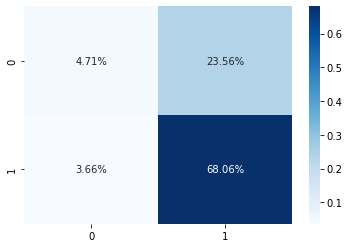

In [51]:
# constructing the confusion matrix
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues')

<AxesSubplot:>

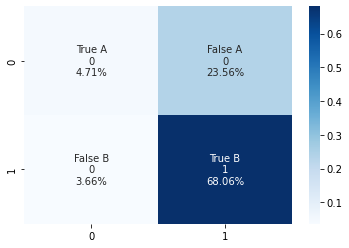

In [52]:
# or constructing the confusion matrix in a better way
group_names = ['True A', 'False A', 'False B', 'True B']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [53]:
# meaning of the confusion matrix

#              Predicted Labels
#                  | 0 - A                | 1 - B
# -------------------------------------------------------------------------------------
# True label 0-A  | True positive (TP)   | False negative (FN)
#            ------------------------------------------------------------------------------
#            1-B | False positive (FP)  | True negative (TN)
#  

# True positive (TP) stands for True Positive which indicates the number of positive examples classified accurately.
# A test result that correctly indicates the presence of a condition or characteristic.
# True negative (TN) shows the number of negative examples classified accurately.
# A test result that correctly indicates the absence of a condition or characteristic.
# False positive (FP) is the number of actual negative examples classified as positive.
# A test result which wrongly indicates that a particular condition or attribute is present.
# False negative (FN) is the number of actual positive examples classified as negative.
# A test result which wrongly indicates that a particular condition or attribute is absent.

# our model has a good level 68,06% of  predicting true negatives for 1.

In [54]:
# end

In [55]:
# # without categorical and normalizing
# X = pd.get_dummies(data.drop('rental_month', axis=1))
# y = data['rental_month']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# classification = LogisticRegression(random_state=42, max_iter=10000)
# classification.fit(X_train, y_train)

# predictions = classification.predict(X_test)
# print(classification_report(y_test, predictions))

In [56]:
# # Build X and y
# y = data['rental_month']
# X = data.drop(['rental_month'], axis=1)

In [57]:
# # split train and test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
# # split numericals and categoricals
# X_train_df = pd.DataFrame(X_train, columns=X.columns)
# X_test_df  = pd.DataFrame(X_test,  columns=X.columns)

# X_train_num = X_train_df.select_dtypes(include = np.number)
# X_test_num  = X_test_df.select_dtypes(include = np.number)
# X_train_cat = X_train_df.select_dtypes(include = np.object)
# X_test_cat  = X_test_df.select_dtypes(include = np.object)

In [59]:
# # scale numericals
# from sklearn.preprocessing import MinMaxScaler
# #from sklearn.preprocessing import StandardScaler

# # Normalizing data
# transformer = MinMaxScaler().fit(X_train_num) # we will reuse this transformer for X_test later
# X_train_scaled_arr = transformer.transform(X_train_num)
# X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train_num.columns)
# X_train_scaled.head()

In [60]:
# # encode categoricals
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(drop='first').fit(X_train_cat)
# encoded_cat = encoder.transform(X_train_cat).toarray()
# cols = encoder.get_feature_names(input_features=X_train_cat.columns)
# # we will reuse encoder and cols when encoding the X_test_cat
# onehot_encoded = pd.DataFrame(encoded_cat, columns=cols)
# onehot_encoded.head()

In [61]:
# X_train_treated = pd.concat([X_train_scaled, onehot_encoded], axis=1)

In [62]:
# from sklearn.linear_model import LogisticRegression
# classification = LogisticRegression(random_state=0, solver='lbfgs',
#                   multi_class='ovr')
# classification.fit(X_train_treated, y_train)

In [63]:
# # apply scaler to X_test_num
# X_test_scaled_arr = transformer.transform(X_test_num)
# X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test_num.columns)
# X_test_scaled.head()